In [3]:
# Imports
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [13]:
# Diccionary with the list of fruits
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
fruit_dict = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        fruit_dict[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [14]:
# Audio parameters
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.
HOP_SIZE   = 256

In [15]:
# Function to load the audio signal
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = len(test_audio)/sr
    return test_audio, sr, duration

In [6]:
# Function to plot the signal
def plot_signal(signal, sample_rate):
    # Duration and time vector
    duration = len(signal)/sample_rate
    
    # Time_vector
    time_vector = np.linspace(0, duration, len(signal))
    
    # Figure
    plt.figure(figsize=(15, 5))
    
    #plot
    librosa.display.waveshow(signal, sr=sample_rate, axis='time')
    
    #plt.plot(time_vector, signal, linestyle='-')
    
    # extra
    plt.title(f'Señal de Audio - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

In [8]:
# Low pass filter
def low_pass_filter(signal, cutoff_frequency, sample_rate):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

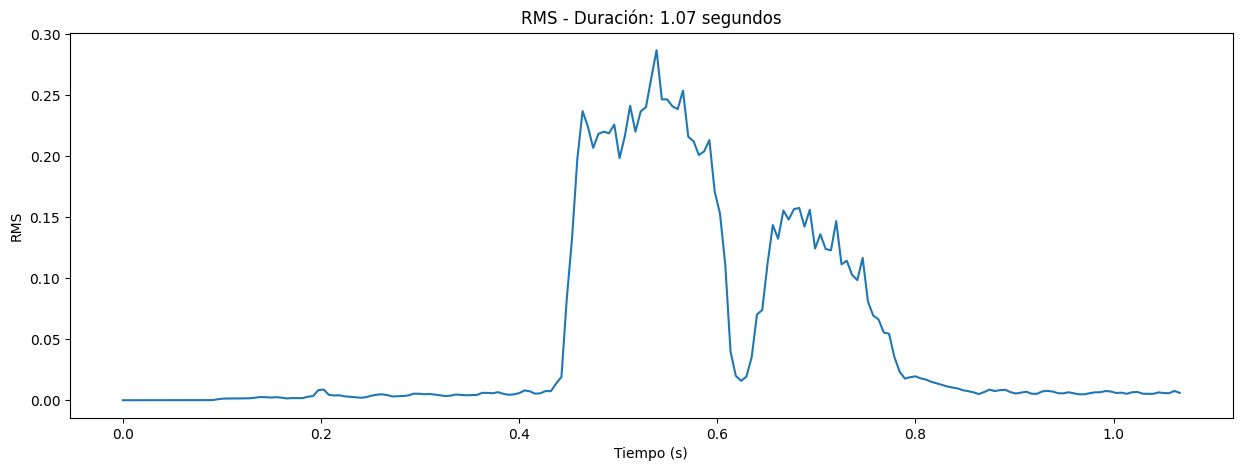

In [9]:
# Function to get the RMS values
def get_rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [16]:
# Function to trim the audio signal
def trim(signal, perc):             # The audio signal and the percentaje umbral
    signal_rms = signal.get_rms()   # RMS values for each fram
    max_rms = signal_rms.max()      # Max RMS

    umbral = perc*max_rms/100       # Umbral

    mask_rms = signal_rms > umbral

    rms_bottom_index = np.argmax(mask_rms)
    rms_upper_index = mask_rms.shape[1] - np.argmax(np.flip(mask_rms))

    bottom_index = HOP_SIZE*rms_bottom_index
    upper_index  = HOP_SIZE*(rms_upper_index + 1)

    return signal[bottom_index:upper_index]   # Trimmed signal

In [3]:
# Bucle
for _, fruits in fruit_dict.items():
    for fruit in fruits:
        signal, sr, duration = load_audio(fruit)
        signal = trim(signal, 15)

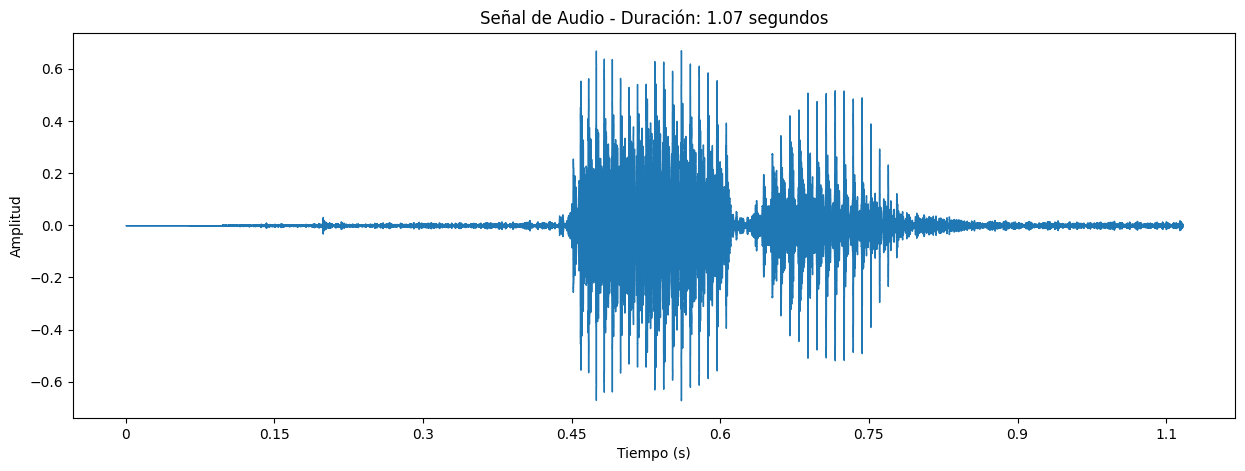

In [7]:
# Plot de la señal pura
plot_signal(test_audio, sr)

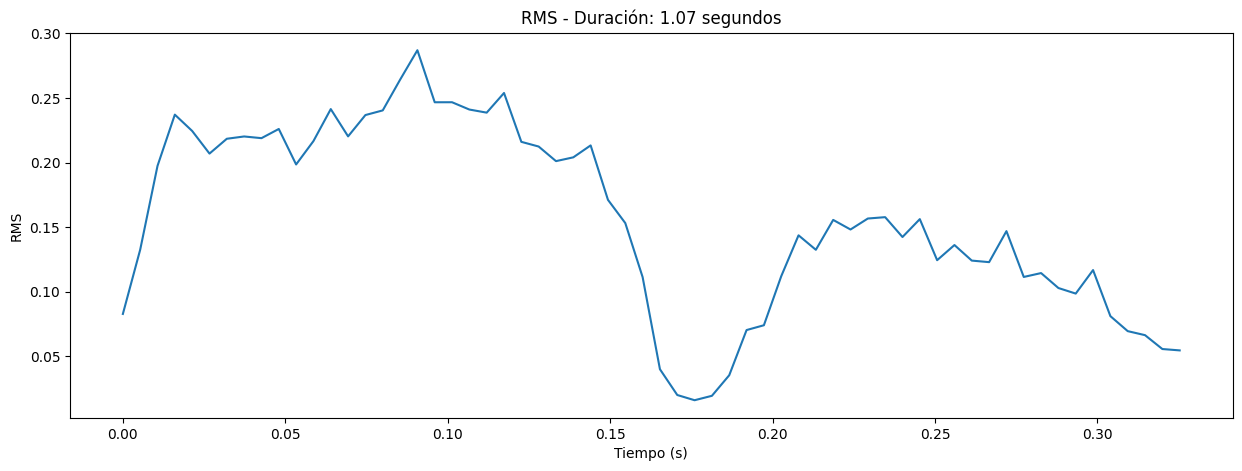

In [11]:
# plot para el RMS recortado
plt.figure(figsize=(15, 5))
plt.plot(librosa.times_like(aux_rms, sr=sr, hop_length = HOP_SIZE), aux_rms)
plt.title(f'RMS - Duración: {Duration:.2f} segundos')
plt.xlabel('Tiempo (s)')
plt.ylabel('RMS')
plt.show()

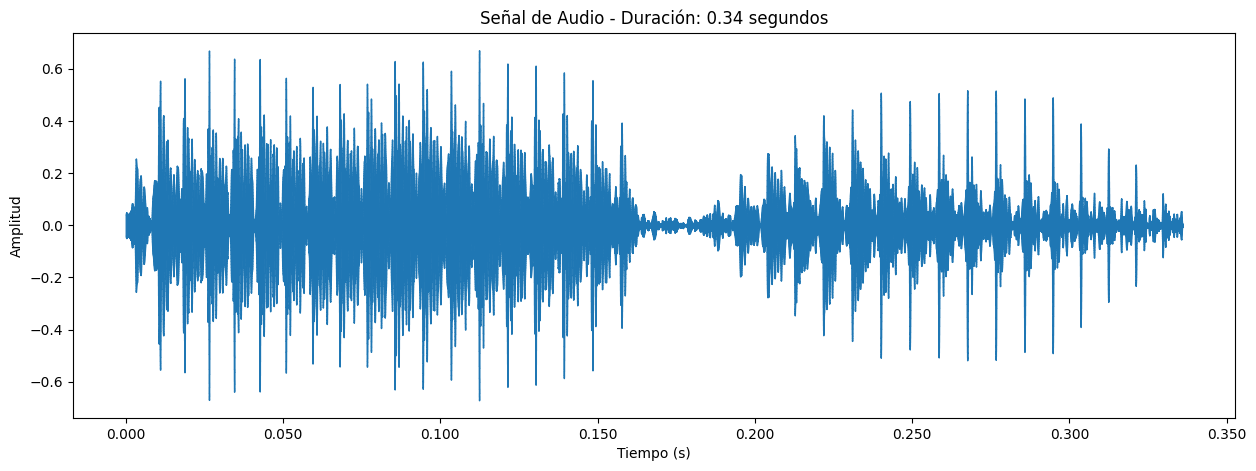

In [12]:
#plot para la señal recortada
plot_signal(test_cut, sr)

In [13]:
#Tratar de reconstruir el audio
ipd.Audio(data = test_cut, rate = sr)

In [14]:
# Obtención del espectrograma puro (STFT)
stft_test = librosa.stft(test_cut, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [15]:
# Obtención de la magnitud para el ploteo
power_test = np.abs(stft_test) ** 2

In [16]:
# Función de ploteo del espectrograma
def plot_spectrogram(stft_power, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(stft_power, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
    plt.show()

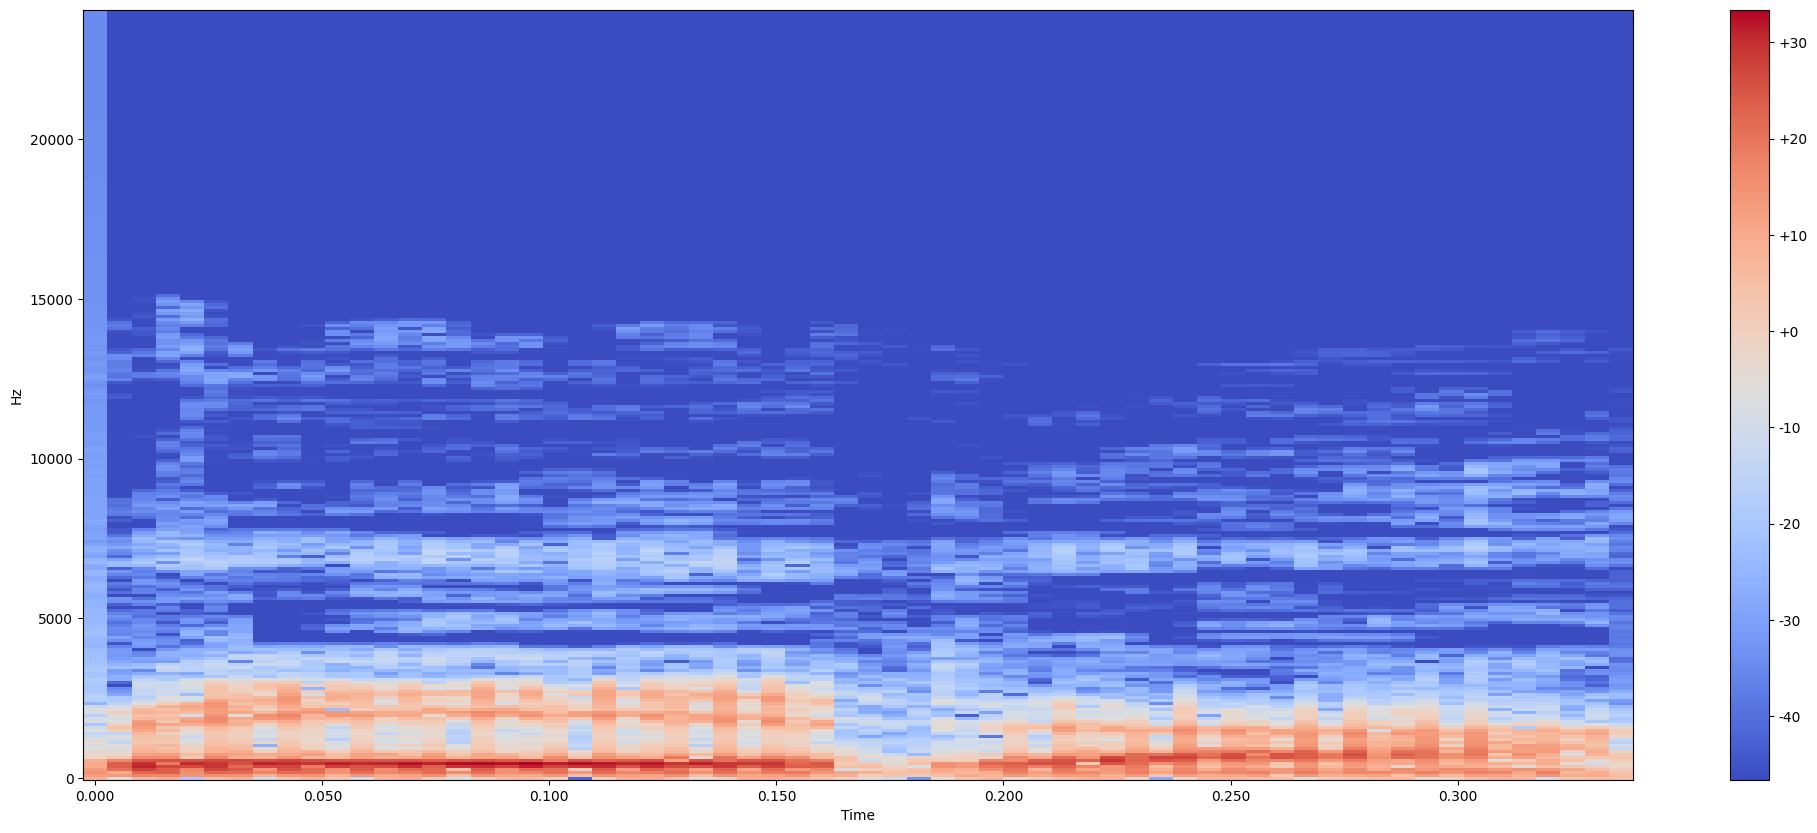

In [17]:
# Espectrograma en amplitud logarítmica.
logpower_test = librosa.power_to_db(power_test) # Simplemente hace la transf. logarítmica.
plot_spectrogram(logpower_test, sr, HOP_SIZE)

In [18]:
# Obtención del espectrograma de mel
mel_spectrogram_test = librosa.feature.melspectrogram(y = test_cut, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=20)

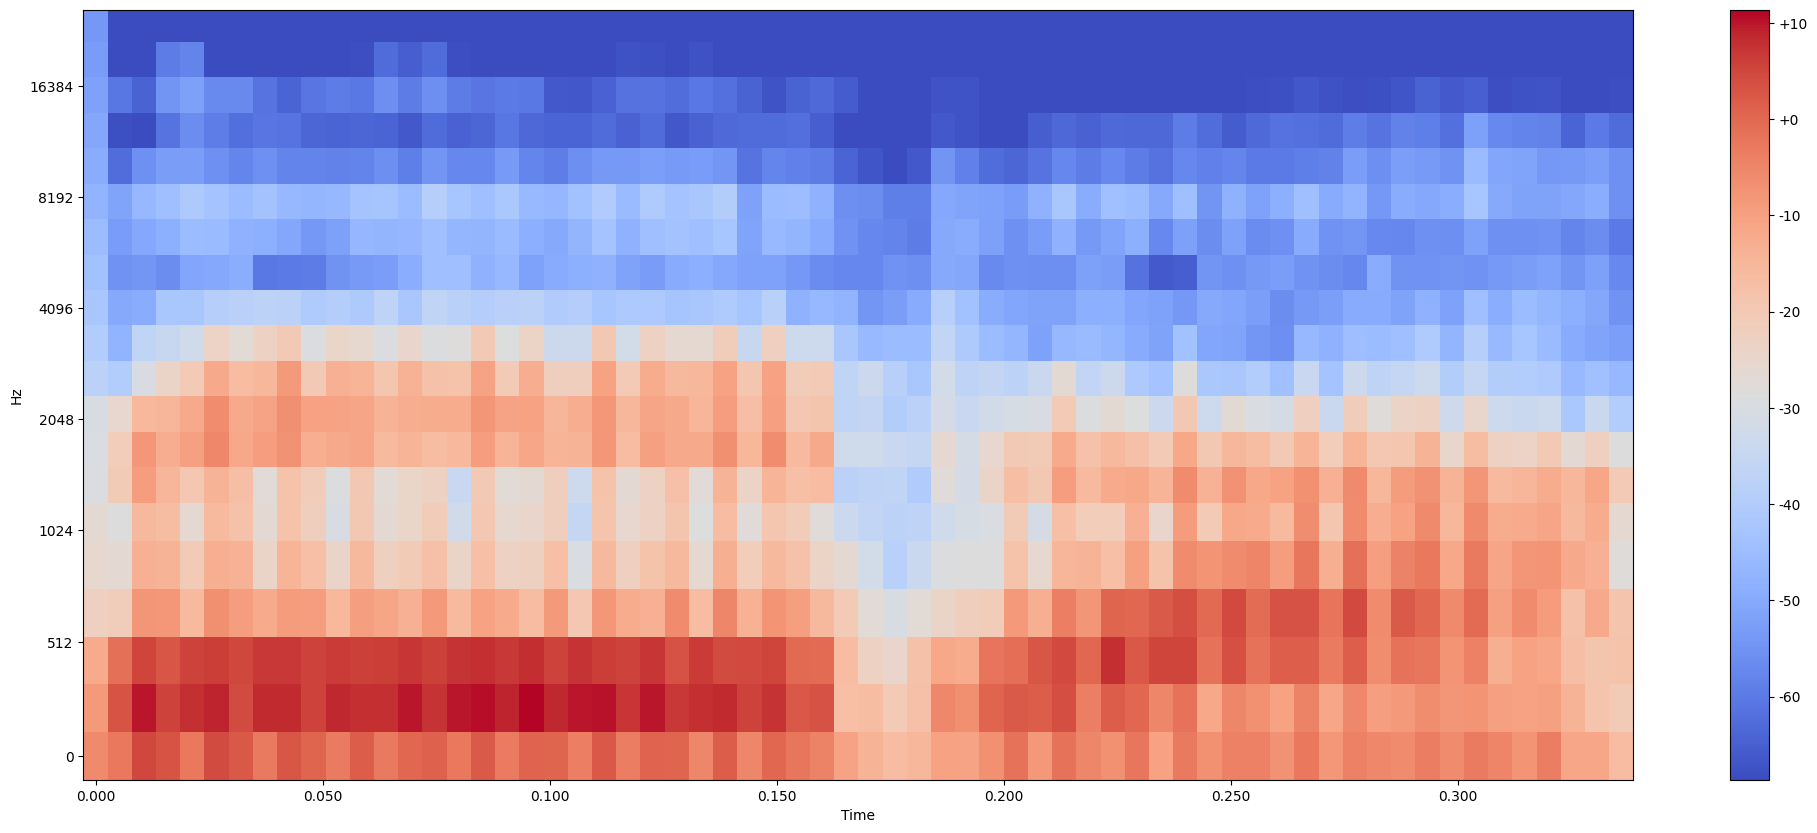

In [19]:
# Espectrograma de mel del test_audio en db
log_mel_spectrogram_test = librosa.power_to_db(mel_spectrogram_test)
plot_spectrogram(log_mel_spectrogram_test, sr, HOP_SIZE, 'mel')

In [20]:
# Obtencion de los mel frequency cepstral coeficcients
mfccs = librosa.feature.mfcc(y=test_cut, n_mfcc=20, sr=sr)

In [21]:
# Obtenemos un promedio de los coeficientes a través de todo el audio para obtener una representacion del mismo
mean_rows = np.mean(mfccs, axis=1)


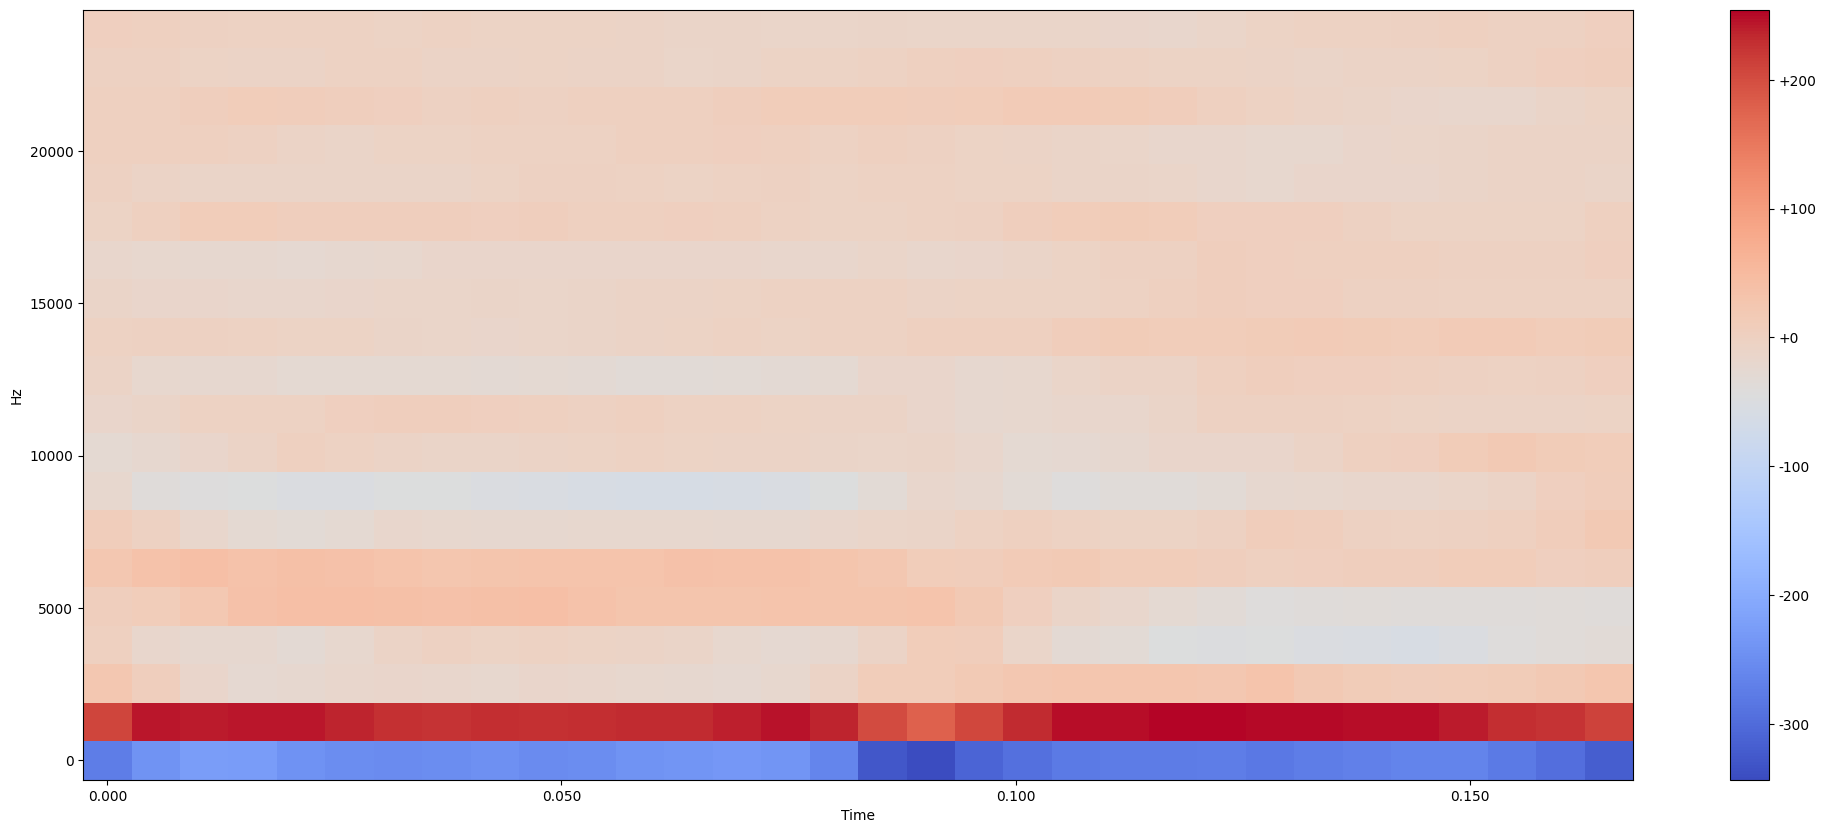

In [22]:
# Grafico de los coeficientes de mel
plot_spectrogram(mfccs, sr, HOP_SIZE)